In [7]:
import numpy as np
import scipy.stats as sps
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(font_scale=1.3)

# Random Forest и переобучение

**Переобучение** -- явление, при котором построенная модель хорошо объясняет примеры из обучающей выборки, но относительно плохо работает на объектах, не участвовавших в обучении (из тестовой выборки).

Это связано с тем, что при построении модели («в процессе обучения») в обучающей выборке обнаруживаются некоторые случайные закономерности, которые отсутствуют в глобальном смысле.

In [8]:
def cum_metric(model, metric, x_test, y_test, shuffle=False):
    """
    Считает значения метрики metric в зависимости от количества деревьев
    в обученной модели model метом композиции деревьев.
    Если shuffle=True, то для рассчета перемешивает деревья.
    """
    
    # считаем предсказания по каждому дереву отдельно
    predictions_by_estimators = [est.predict(x_test) for est in model.estimators_]
    
    if shuffle:
        from random import shuffle
        shuffle(predictions_by_estimators)
        
    # Кумулятивное среднее предсказаний
    cumpred = np.array(predictions_by_estimators).cumsum(axis=0) \
               / (np.arange(len(predictions_by_estimators)) + 1)[:, np.newaxis]
    
    cumacc = [metric(y_test, pred) for pred in cumpred]
    return np.array(cumacc)

## 1. Сильно шумные данные

Сгенерируем сильно зашумленную зависимость:
* $x$ выбирается случайно на отрезке $[-5, 5]$
* $y=x$ + большой шум $\mathcal{N}(0, 10^2)$
* Признаки: сам $x$ и его квадрат. 

Обучим на этих данных Random Forest на 200 деревьев и обычную линейную регрессию.

In [118]:
train_size = 100
poly_degree = 2
noise_scale = 10
n_estimators = 200

x_train = sps.uniform(loc=-5, scale=10).rvs(size=(train_size, 1))
y_train = x_train.ravel() + sps.norm(scale=noise_scale).rvs(size=train_size)
features_train = x_train ** np.arange(1, poly_degree+1)

rf = RandomForestRegressor(n_estimators=n_estimators).fit(features_train, y_train)
lr = LinearRegression().fit(features_train, y_train)

Для обоих методов построим предсказания по сетке. Как видим, предсказания Random Forest очень шумные, явно видно сильно переобучение.

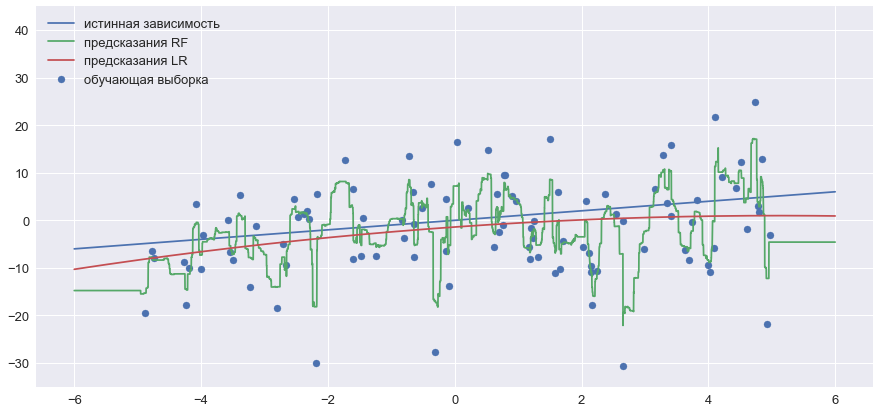

In [70]:
grid = np.arange(-6, 6, 0.001)
features_test = grid[:, np.newaxis] ** np.arange(1, poly_degree+1)
preds_rf = rf.predict(features_test)
preds_lr = lr.predict(features_test)

plt.figure(figsize=(15, 7))
plt.plot(grid, grid, label='истинная зависимость')
plt.plot(grid, preds_rf, label='предсказания RF')
plt.plot(grid, preds_lr, label='предсказания LR')
plt.scatter(x_train, y_train, label='обучающая выборка')
plt.legend(loc=2)
plt.ylim((-35, 45));

Посчитаем MSE на трейне и на тесте для обоих моделей. Как видим, ошибка на тесте для RF существенно выше ошибки на трейне, это явно говорит о сильном переобучении.  В то же время ошибки для линейной регрессии слабо отличаются, т.е. возможно линейная регрессия не переобучается. Более того, ошибка на тесте для линейной регрессии существенно ниже ошибки для RF.

In [71]:
# зашумляем метки на тесте аналогичным образом
y_grid = grid + sps.norm(scale=noise_scale).rvs(size=len(grid))

print('RF: mse_train = {:.2f}'.format(mean_squared_error(y_train, rf.predict(features_train))))
print('RF: mse_test = {:.2f}'.format(mean_squared_error(y_grid, rf.predict(features_test))))
print('LR: mse_train = {:.2f}'.format(mean_squared_error(y_train, lr.predict(features_train))))
print('LR: mse_test = {:.2f}'.format(mean_squared_error(y_grid, lr.predict(features_test))))

RF: mse_train = 18.02
RF: mse_test = 156.92
LR: mse_train = 98.39
LR: mse_test = 109.58


### 1.1 Зависимость от количества деревьев для одной модели

Построим график зависимости MSE от количества деревьев в RF для трейна и для теста. Как видим, начиная с некоторого момента ошибка на тесте начинает расти, в то время как ошибка на трейне падает. Это так же является признаком переобучения.

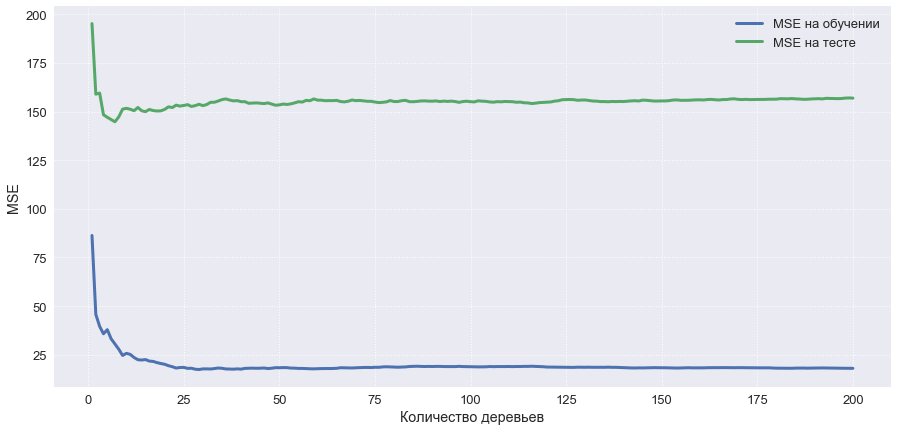

In [72]:
cum_mse_train = cum_metric(rf, mean_squared_error, features_train, y_train)
cum_mse_test = cum_metric(rf, mean_squared_error, features_test, y_grid)
estrimator_range = np.arange(n_estimators) + 1

plt.figure(figsize=(15, 7))
plt.plot(estrimator_range, cum_mse_train, label='MSE на обучении', lw=3)
plt.plot(estrimator_range, cum_mse_test, label='MSE на тесте', lw=3)
plt.grid(ls=':')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.legend();

**НО!** Это свойство конкретной **реализации** модели. Вспоминаем, что RF это усреднение независимых одинаково распределенных случайных деревьев. Т.е. мы получили **свойство, верное для выпавшего элементарного исхода** из вероятностного пространства (random_state), что не означает его выполнение для всех других элементарных исходов.

Вообще, нет никакой причины, почему RF в среднем должен переобучаться с увеличением количества деревьев, ведь мы просто усредняем независимые (при фикс. выборке) одинаково распределенные деревья.
Если бы так было, то мы могли бы просто перемешать деревья, в результате чего такого переобучения не будет.

**Переставим деревья** в нашей обученной модели случайный образом. Как видим, теперь ошибка на тесте в целом падает с ростом количества деревьев.

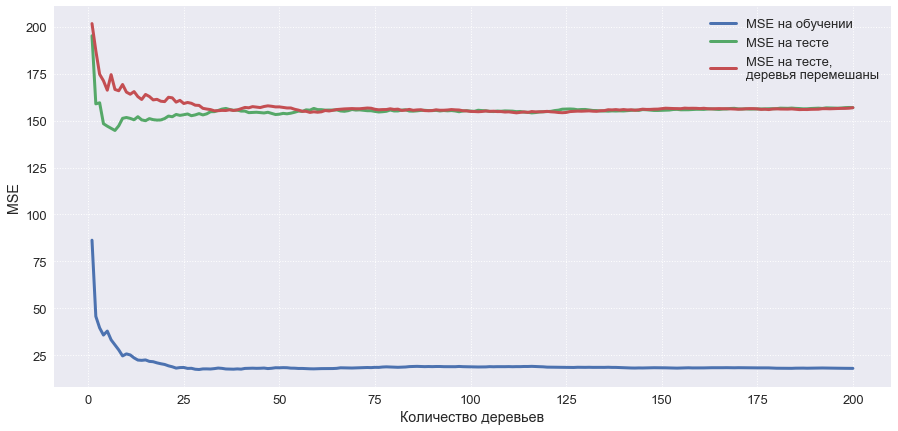

In [75]:
cum_mse_train = cum_metric(rf, mean_squared_error, features_train, y_train)
cum_mse_test = cum_metric(rf, mean_squared_error, features_test, y_grid)
cum_mse_test_shuffle = cum_metric(rf, mean_squared_error, features_test, y_grid, shuffle=True)

plt.figure(figsize=(15, 7))
plt.plot(estrimator_range, cum_mse_train, label='MSE на обучении', lw=3)
plt.plot(estrimator_range, cum_mse_test, label='MSE на тесте', lw=3)
plt.plot(estrimator_range, cum_mse_test_shuffle, label='MSE на тесте,\nдеревья перемешаны', lw=3)
plt.grid(ls=':')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.legend();

Чтобы лучше понять, посчитаем ошибку по каждом конкретному дереву

In [76]:
def metric_trees(model, metric, x_test, y_test):
    predictions_by_estimators = [est.predict(x_test) for est in model.estimators_]
    predictions_by_estimators = np.array(predictions_by_estimators)
    values = [metric(y_test, pred) for pred in predictions_by_estimators]
    return np.array(values)

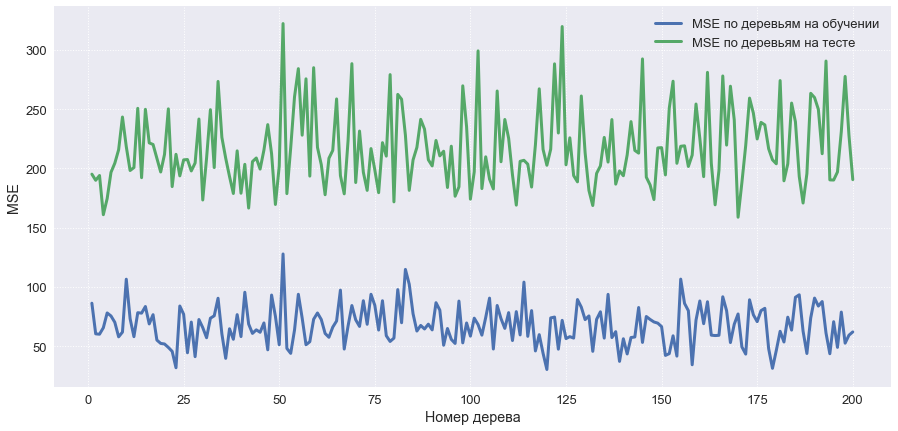

In [77]:
trees_mse_train = metric_trees(rf, mean_squared_error, features_train, y_train)
trees_mse_test = metric_trees(rf, mean_squared_error, features_test, y_grid)

plt.figure(figsize=(15, 7))
plt.plot(estrimator_range, trees_mse_train, label='MSE по деревьям на обучении', lw=3)
plt.plot(estrimator_range, trees_mse_test, label='MSE по деревьям на тесте', lw=3)
plt.grid(ls=':')
plt.xlabel('Номер дерева'), plt.ylabel('MSE')
plt.legend();

Как видим, **звезды так совпали**, что в начале идут деревья только с относительно низкой ошибкой, в следствии чего для всего леса ошибка с ростом количества деревьев возрастает.

Интересно, что будет если оставить **только "хорошие" деревья**, т.е. те, для которых ошибка не сильно велика. В таком случае можно получить лучшее качество композиции, но лишь немного.

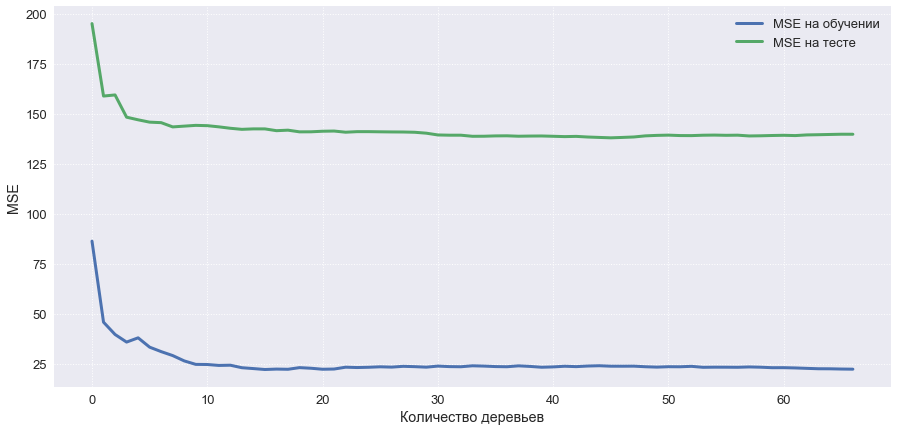

In [78]:
rf.estimators_ = np.array(rf.estimators_)[trees_mse_test < 200]

cum_mse_train = cum_metric(rf, mean_squared_error, features_train, y_train)
cum_mse_test = cum_metric(rf, mean_squared_error, features_test, y_grid)

plt.figure(figsize=(15, 7))
plt.plot(cum_mse_train, label='MSE на обучении', lw=3)
plt.plot(cum_mse_test, label='MSE на тесте', lw=3)
plt.grid(ls=':')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.legend();

### 1.2 Зависимость от количества деревьев в среднем

Если же мы будем рассматривать среднюю ошибку по всем моделям, то она будет монотонно убывать.
Получим это с помощью симуляции.
Для этого **10000 раз обучим модель RF**, по каждой посчитаем кривые и усредним.

In [ ]:
n_estimators = 200
n_iterations = 10000
scores_train = np.zeros((n_iterations, n_estimators))
scores_test = np.zeros((n_iterations, n_estimators))
estrimator_range = np.arange(n_estimators) + 1

for i in tqdm(range(n_iterations)):
    rf = RandomForestRegressor(n_estimators=n_estimators).fit(features_train, y_train)
    # Считаем точность классификации для всех "кумулятивных" наборах поддеревьев
    scores_train[i] = cum_metric(rf, mean_squared_error, features_train, y_train)
    scores_test[i] = cum_metric(rf, mean_squared_error, features_test, y_grid)

На графике ниже изображено 10000 синих кривых, которые есть ошибка на тесте в засимости от количества деревьев для каждой конкретной модели. Зеленая кривая есть их усреднение. Аналогично, розовые кривые есть ошибка на тесте.

Как видно из графика, зеленые кривые монотонно убывают. Так же на графике заметен провал для некоторых синих кривых при небольшом количестве деревьев. Этот провал соответствует случаям, в которых в начале попадались только хорошие деревья. На зеленой кривой такого провала нет, поскольку есть случаи с очень плохими деревьями.

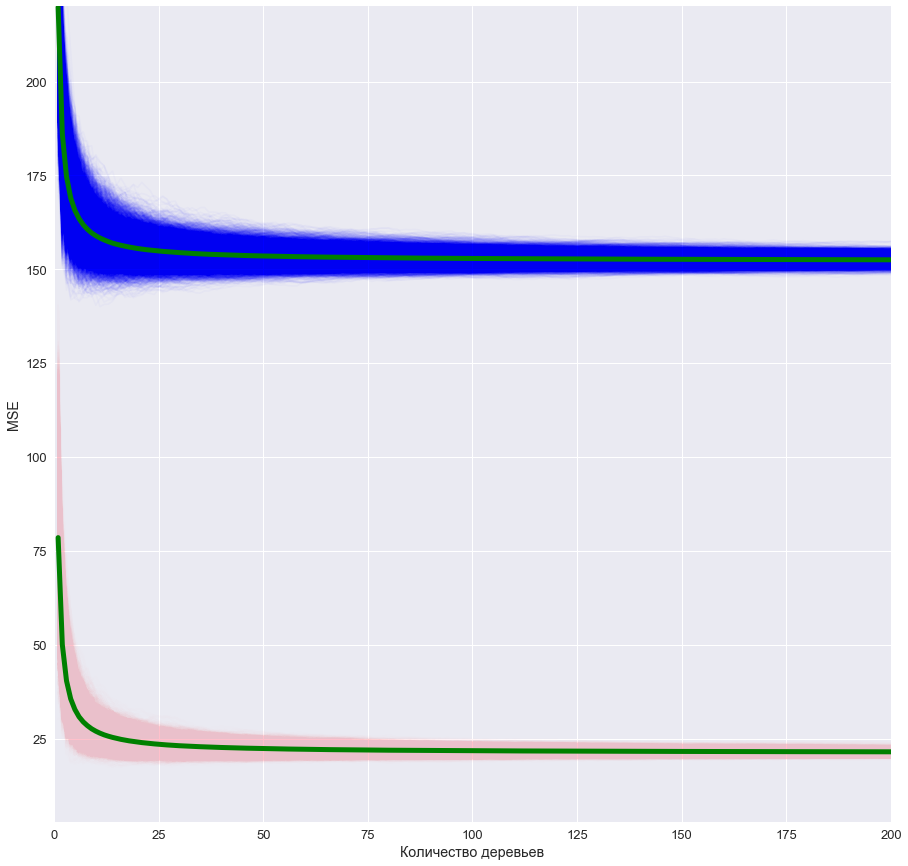

In [120]:
plt.figure(figsize=(15, 15))
for i in range(n_iterations):
    plt.plot(estrimator_range, scores_train[i], color='pink', alpha=0.02)
    plt.plot(estrimator_range, scores_test[i], color='blue', alpha=0.02)
plt.plot(estrimator_range, scores_train.mean(axis=0), lw=5, color='green')
plt.plot(estrimator_range, scores_test.mean(axis=0), lw=5, color='green')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.xlim((0, 200)), plt.ylim((None, 220))
plt.show()

Отсюда можно сделать вывод про подбор оптимального количества деревьев. Подбор стоит делать только в случае рассмотрения одной конкретной реализации модели. Если же рассматривать среднюю ошибку, то она тем меньше, чем больше деревьев. Например, **бесполезно обучать модель заново на подобранное количество деревьев по одной реализации.**

Почему же в **среднем ошибка монотонно падает**? Обратимся к лекции:
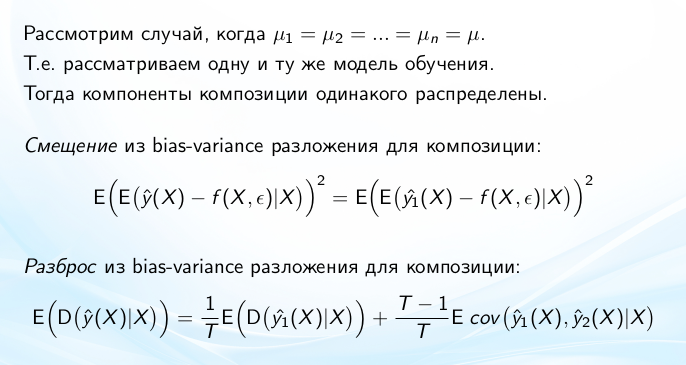

Как видим, bias-компонентна не меняется с увеличением количества деревьев, а variance-компонентна монотонно убывает к значению ковариации двух моделей. Они будут зависимы, т.к. обучаются на одной выборке.

**Подробнее.** Пусть
* $\sigma^2(X)$ --- условная дисперсия из variance-компоненты
* $\rho(X)$ --- условная корреляция, соответствующая ковариации из variance-компоненты. 

Поскольку модели одинаково распределены, то ковариация равна $\sigma^2(X) \rho(X)$.
Распишем variance-компоненту:
$$\frac{1}{T} \mathsf{E} \sigma^2(X) + \frac{T-1}{T} \mathsf{E} \sigma^2(X) \rho(X) = \mathsf{E} \sigma^2(X) \left( \frac{1}{T} + \frac{T-1}{T} \rho(X) \right) = $$
$$ = \mathsf{E} \sigma^2(X) \left( \frac{1+T\rho(X)-\rho(X)}{T} \right) = \mathsf{E} \sigma^2(X) \left( \rho(X) + \frac{1-\rho(X)}{T} \right) \longrightarrow \mathsf{E} \sigma^2(X) \rho(X)$$


### 1.3 Зависимость от максимальной глубины дерева

А как качество зависит от максимальной глубины деревьев?
Для этого для каждого значения глубины обучим RF на 200 деревьев 500 раз.
Посчитаем качество и построим предсказательные интервалы для значения ошибки конкретного леса, т.е. учтем как ошибку определения среднего, так и разброс конкретных реализаций.

In [ ]:
depths = np.arange(2, 15)
n_estimators = 200
n_iterations = 500
scores_train = np.zeros((n_iterations, len(depths)))
scores_test = np.zeros((n_iterations, len(depths)))

for i in tqdm(range(n_iterations)):
    for max_depth in depths:
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth).fit(features_train, y_train)
        scores_train[i, max_depth-2] = mean_squared_error(y_train, rf.predict(features_train))
        scores_test[i, max_depth-2] = mean_squared_error(y_grid, rf.predict(features_test))

Как видим, ошибка на тесте растет с увеличением разрешенной глубины, в то время как на трейне она падает

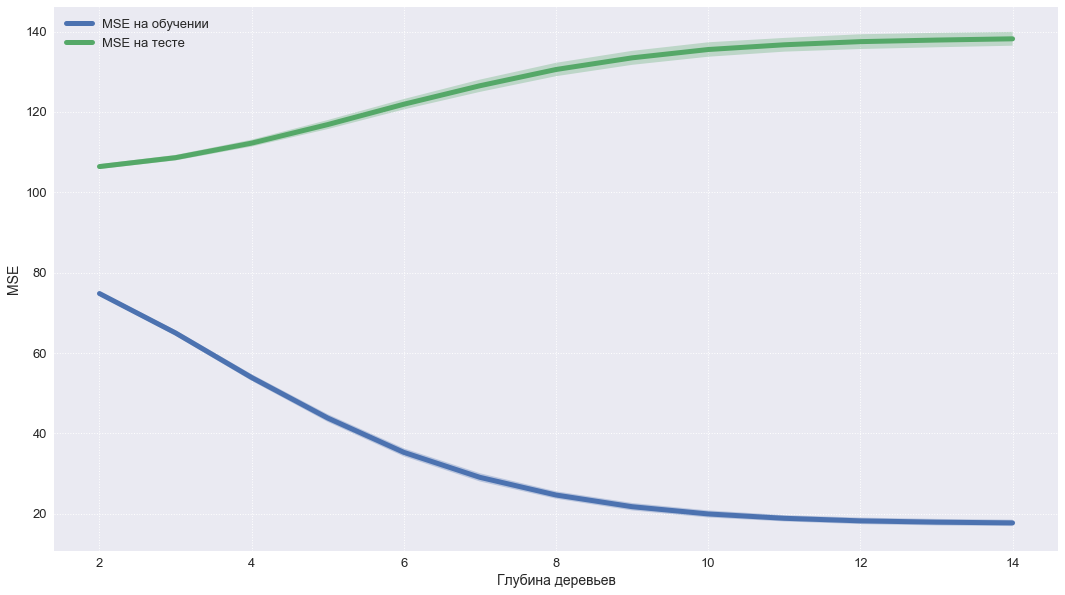

In [117]:
plt.figure(figsize=(18, 10))
for scores, label in zip([scores_train, scores_test], ['MSE на обучении', 'MSE на тесте']):
    means = scores.mean(axis=0)
    std = scores.std(axis=0)
    deviations_value = std * 2 * np.sqrt(1 + 1 / n_iterations)
    plt.plot(depths, means, lw=5, label=label)
    plt.fill_between(depths, means - deviations_value, means + deviations_value, alpha=0.3)
plt.xlabel('Глубина деревьев', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.grid(ls=':')
plt.legend()
plt.show()

Опимальная глубина для теста равна 2. Посмотрим на сами предсказания для этой глубины. Стало значительно лучше.

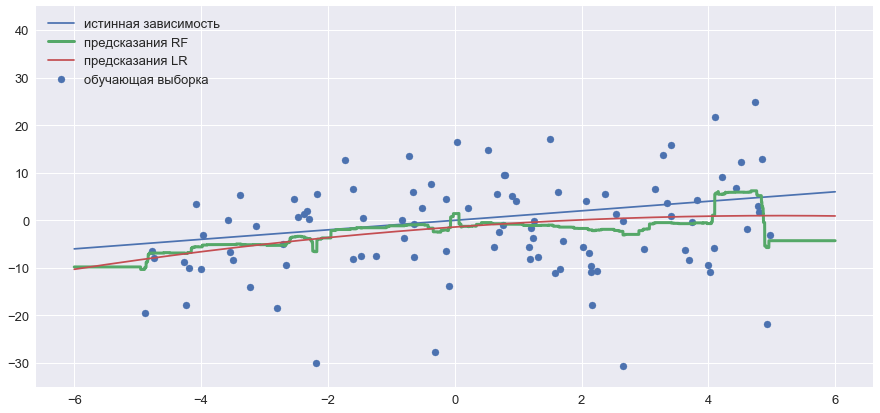

In [98]:
rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=2).fit(features_train, y_train)

grid = np.arange(-6, 6, 0.001)
features_test = grid[:, np.newaxis] ** np.arange(1, poly_degree+1)
preds_rf = rf.predict(features_test)
preds_lr = lr.predict(features_test)

plt.figure(figsize=(15, 7))
plt.plot(grid, grid, label='истинная зависимость')
plt.plot(grid, preds_rf, label='предсказания RF', lw=3)
plt.plot(grid, preds_lr, label='предсказания LR')
plt.scatter(x_train, y_train, label='обучающая выборка')
plt.legend(loc=2)
plt.ylim((-35, 45));

## 2. Не сильно шумные данные

Наконец, посмотрим, как зависит ошибка от глубины деревьев в случае если данные не сильно шумные. Для этого поставим стандартное отклонение шума равным 2 (до этого было 10)

In [110]:
train_size = 100
poly_degree = 2
noise_scale = 2
n_estimators = 200

x_train = sps.uniform(loc=-5, scale=10).rvs(size=(train_size, 1))
y_train = x_train.ravel() + sps.norm(scale=noise_scale).rvs(size=train_size)
features_train = x_train ** np.arange(1, poly_degree+1)

rf = RandomForestRegressor(n_estimators=n_estimators).fit(features_train, y_train)
lr = LinearRegression().fit(features_train, y_train)

In [ ]:
depths = np.arange(2, 15)
n_estimators = 200
n_iterations = 500
scores_train = np.zeros((n_iterations, len(depths)))  # В (i, j) записана точность на j деревьях для запуска i
scores_test = np.zeros((n_iterations, len(depths)))  # В (i, j) записана точность на j деревьях для запуска i

for i in tqdm(range(n_iterations)):
    for max_depth in depths:
        rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth).fit(features_train, y_train)
        scores_train[i, max_depth-2] = mean_squared_error(y_train, rf.predict(features_train))
        scores_test[i, max_depth-2] = mean_squared_error(y_grid, rf.predict(features_test))

Как видим из графика, от глубины почти ничего не зависит.

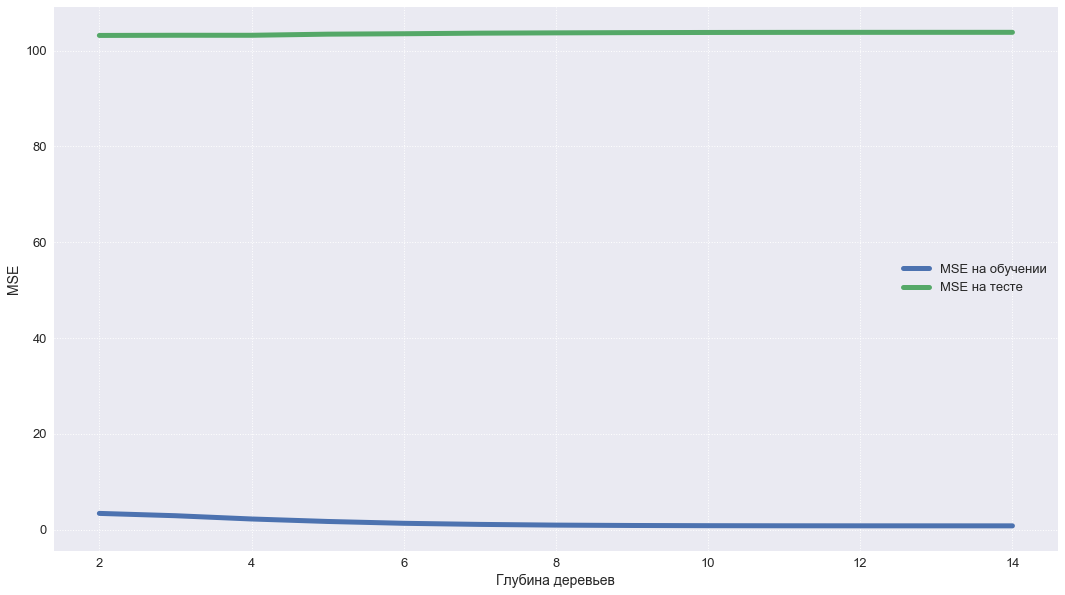

In [114]:
plt.figure(figsize=(18, 10))
for scores, label in zip([scores_train, scores_test], ['MSE на обучении', 'MSE на тесте']):
    means = scores.mean(axis=0)
    std = scores.std(axis=0)
    deviations_value = std * 2 * np.sqrt(1 + 1 / n_iterations)
    plt.plot(depths, means, lw=5, label=label)
    plt.fill_between(depths, means - deviations_value, means + deviations_value, alpha=0.3)
plt.xlabel('Глубина деревьев', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.grid(ls=':')
plt.legend()
plt.show()

Таким образом, **глубину деревьев в RF имеет смысл подбирать только для очень шумных данных.**